### Importing the required libraries

In [1]:
import numpy as np
import pandas as pd

### Loading the dataset

In [2]:
train_set=pd.read_csv('LSTM-Multivariate_pollution.csv')
test_set=pd.read_csv('pollution_test_data1.csv')

### Exploring the dataset

In [3]:
train_set.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


### Handling missing data

In [5]:
train_set.isnull().sum()

,0
date,0
pollution,0
dew,0
temp,0
press,0
wnd_dir,0
wnd_spd,0
snow,0
rain,0


In [6]:
train_set=train_set.drop(columns=['date'])

### Importing the required libraries

In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_set['wnd_dir']=label_encoder.fit_transform(train_set['wnd_dir'])
test_set['wnd_dir']=label_encoder.transform(test_set['wnd_dir'])

In [8]:
features=['dew','temp','press','wnd_dir','wnd_spd','snow','rain']
target='pollution'

In [9]:
X=train_set[features].values
y=train_set[target].values.reshape(-1,1)
X_test=test_set[features].values
y_test=test_set[target].values.reshape(-1,1)

### Feature Scaling

In [10]:
from sklearn.preprocessing import MinMaxScaler
X_scaler=MinMaxScaler()
y_scaler=MinMaxScaler()

X_scaled=X_scaler.fit_transform(X)
y_scaled=y_scaler.fit_transform(y)

X_test_scaled=X_scaler.transform(X_test)
y_test_scaled=y_scaler.transform(y_test)

In [11]:
def create_sequences(X,y,time_steps):
    Xs,ys=[],[]
    for i in range(time_steps,len(X)):
        Xs.append(X[i-time_steps:i])
        ys.append(y[i])
    return np.array(Xs),np.array(ys)

In [12]:
time_steps=24
X_seq,y_seq=create_sequences(X_scaled,y_scaled,time_steps)
X_test_seq,y_test_seq=create_sequences(X_test_scaled,y_test_scaled,time_steps)

### Making the Train Test Split

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X_seq,y_seq,test_size=0.1,random_state=42,shuffle=False)

### Building the LSTM

In [14]:
from tensorflow.keras import layers, models

model=models.Sequential([
    layers.Bidirectional(layers.LSTM(units=256,activation='tanh',return_sequences=True),input_shape=(time_steps,X_train.shape[2])),
    layers.Dropout(rate=0.3),
    layers.Bidirectional(layers.LSTM(units=128,activation='tanh',return_sequences=True)),
    layers.Dropout(rate=0.3),
    layers.Bidirectional(layers.LSTM(units=64,activation='tanh')),
    layers.Dropout(rate=0.3),
    layers.Dense(units=64,activation='relu'),
    layers.Dense(units=1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 24, 512)        │       540,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 24, 256)        │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,369,729 (5.23 MB)

 Trainable params: 1,369,729 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

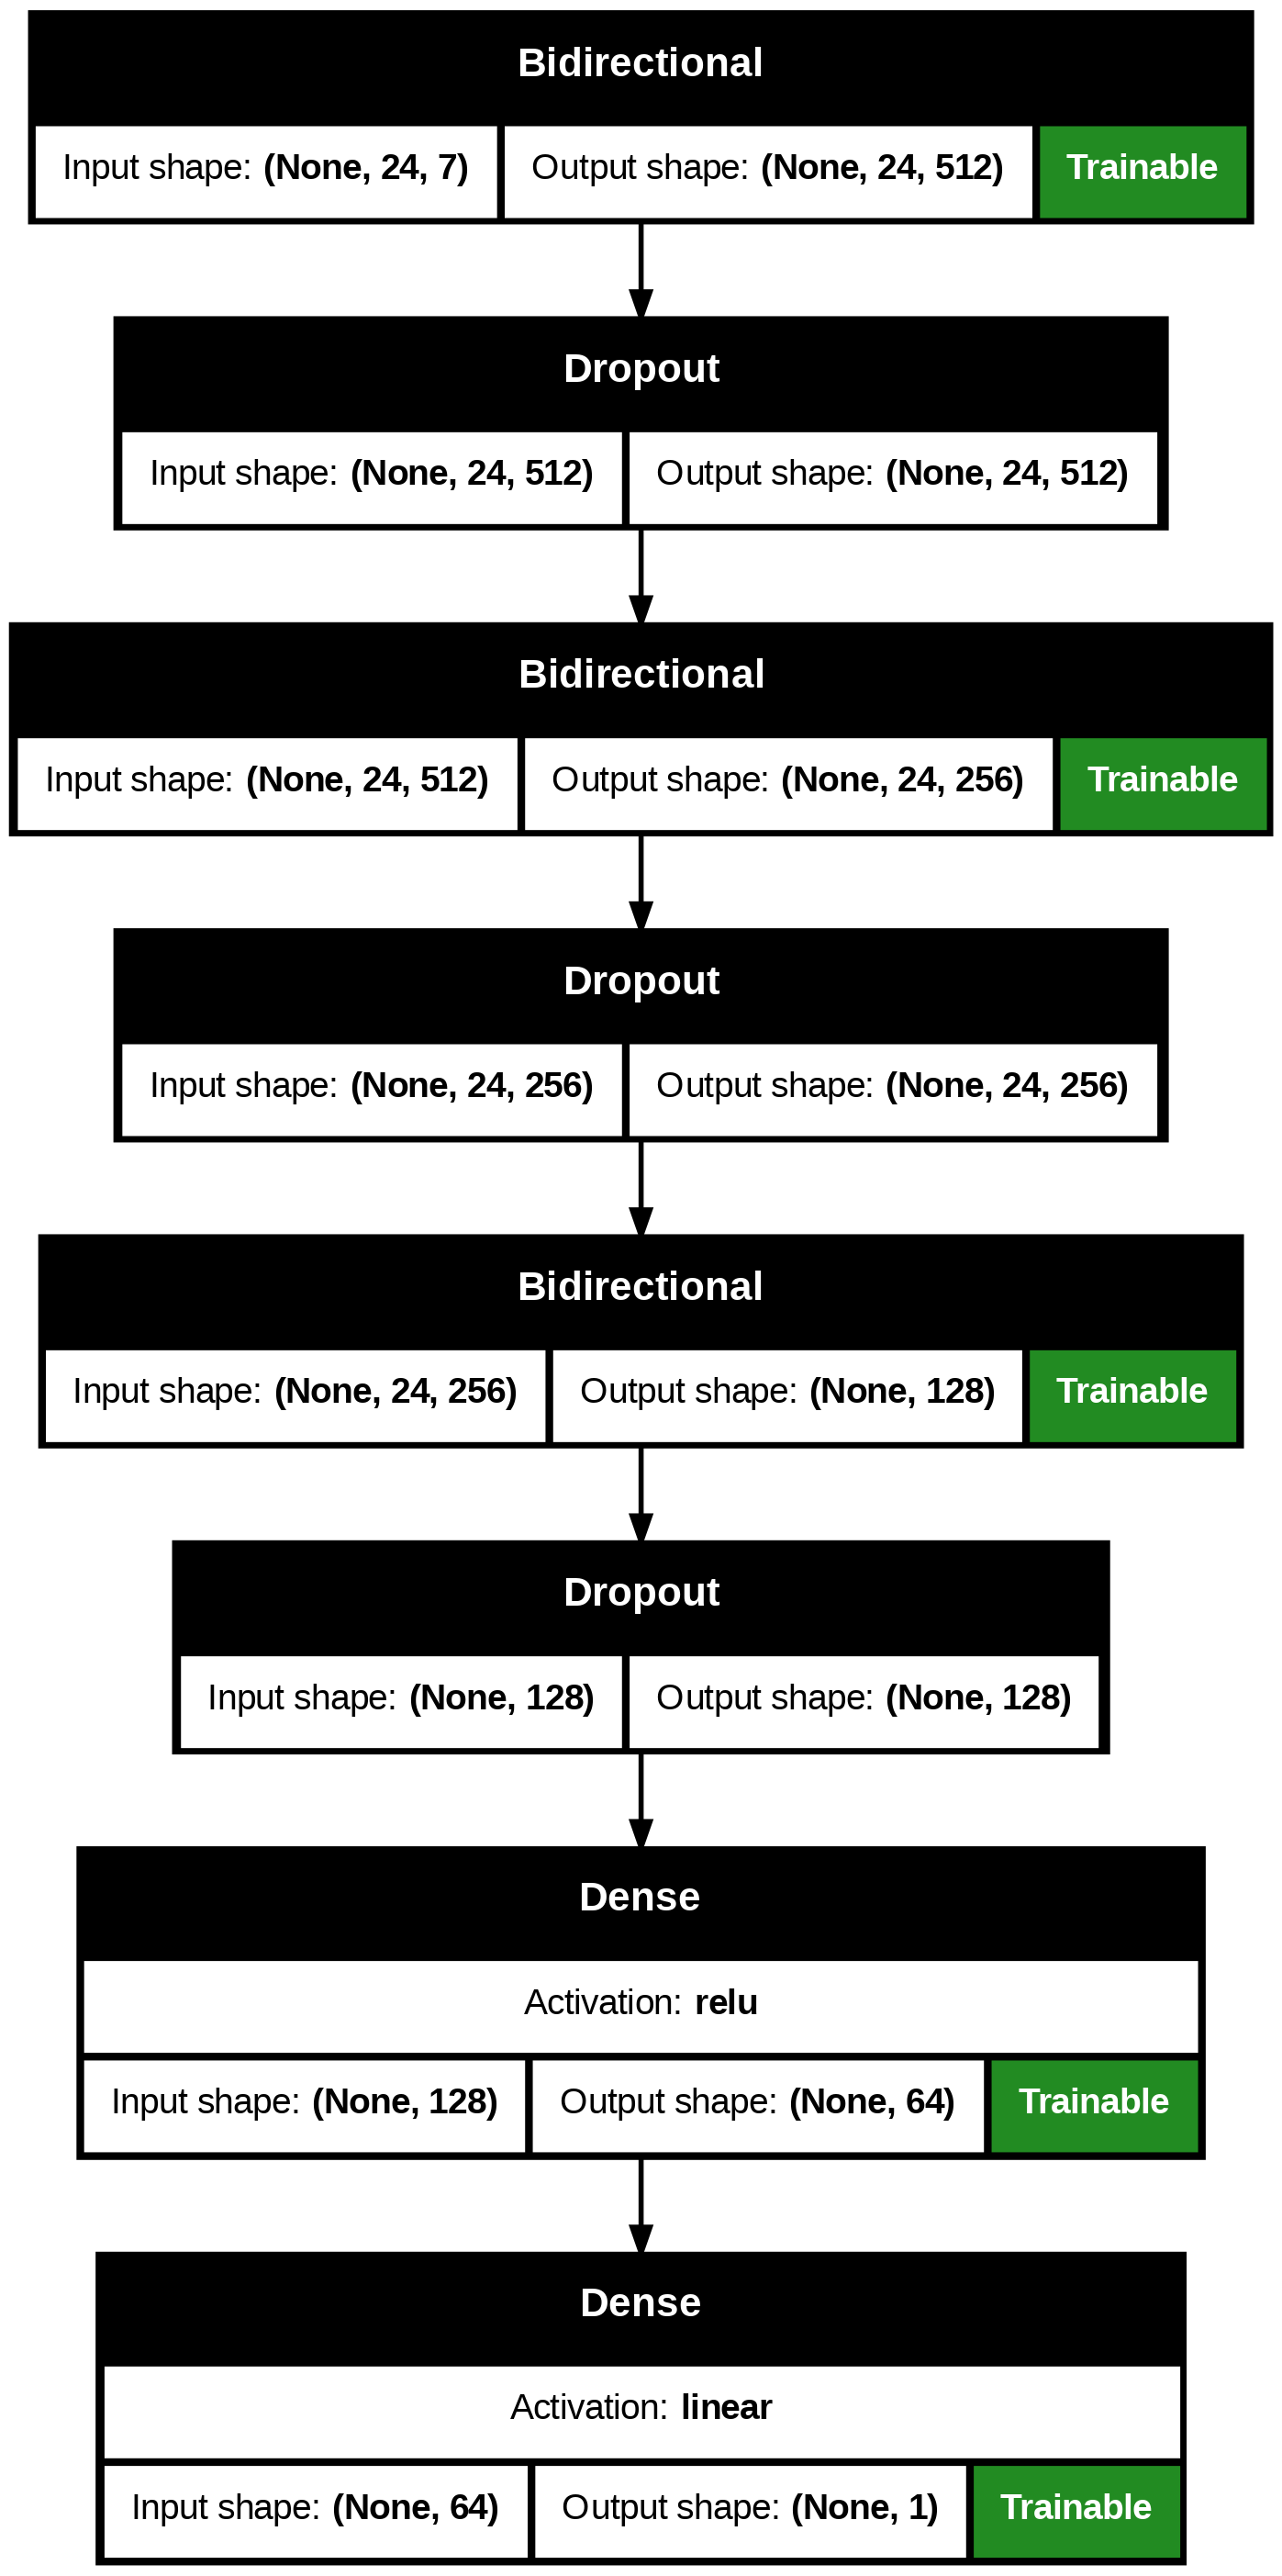

In [16]:
import tensorflow as tf
tf.keras.utils.plot_model(model,dpi=200,show_trainable=True,show_layer_activations=True,show_shapes=True)

### Compiling the LSTM

In [17]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001),loss='huber',metrics=['mae'])

### Training the Model

In [18]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
early_stopper=EarlyStopping(patience=5,restore_best_weights=True,monitor='val_loss')
lr_scheduler=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,min_lr=1e-6)

In [20]:
history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,batch_size=64,verbose=1,callbacks=[early_stopper,lr_scheduler])

Epoch 1/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0041 - mae: 0.0622 - val_loss: 0.0023 - val_mae: 0.0504 - learning_rate: 0.0010
Epoch 2/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.0026 - mae: 0.0502 - val_loss: 0.0019 - val_mae: 0.0431 - learning_rate: 0.0010
Epoch 3/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0025 - mae: 0.0475 - val_loss: 0.0020 - val_mae: 0.0447 - learning_rate: 0.0010
Epoch 4/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0023 - mae: 0.0465 - val_loss: 0.0019 - val_mae: 0.0450 - learning_rate: 0.0010
Epoch 5/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0023 - mae: 0.0462 - val_loss: 0.0019 - val_mae: 0.0444 - learning_rate: 0.0010
Epoch 6/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0021 - mae: 0.0441 - val_loss: 0.0017 - val_mae: 0.0400 - learning_rate: 5.0000e-04
Epoch 7/50
616/616 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0021 - mae: 0.0438 - val_loss: 0.0017 - val_mae: 0.0417 - learning_r

### Evaluating The Model

In [21]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,explained_variance_score
y_test_pred=y_scaler.inverse_transform(model.predict(X_test_seq))
y_test_true=y_scaler.inverse_transform(y_test_seq)
test_mae=mean_absolute_error(y_test_true,y_test_pred)
test_mse=mean_squared_error(y_test_true,y_test_pred)
test_rmse=np.sqrt(test_mse)
test_r2=r2_score(y_test_true,y_test_pred)
test_evs=explained_variance_score(y_test_true,y_test_pred)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


In [22]:
print("\nTest Metrics:")
print(f"MAE: {test_mae:.4f}")
print(f"MSE: {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²: {test_r2:.4f}")
print(f"EVS: {test_evs:.4f}")


Test Metrics:
MAE: 36.2222
MSE: 3638.9363
RMSE: 60.3236
R²: 0.6381
EVS: 0.6424


### Feature scaling

In [23]:
y_val_pred=y_scaler.inverse_transform(model.predict(X_val))
y_val_true=y_scaler.inverse_transform(y_val)
val_mae=mean_absolute_error(y_val_true,y_val_pred)
val_mse=mean_squared_error(y_val_true,y_val_pred)
val_rmse=np.sqrt(val_mse)
val_r2=r2_score(y_val_true,y_val_pred)
val_evs=explained_variance_score(y_val_true,y_val_pred)

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [24]:
print("\nValidation Metrics:")
print(f"MAE: {val_mae:.4f}")
print(f"MSE: {val_mse:.4f}")
print(f"RMSE: {val_rmse:.4f}")
print(f"R²: {val_r2:.4f}")
print(f"EVS: {val_evs:.4f}")


Validation Metrics:
MAE: 35.5793
MSE: 2876.2438
RMSE: 53.6306
R²: 0.6377
EVS: 0.6418


### Plotting the Results

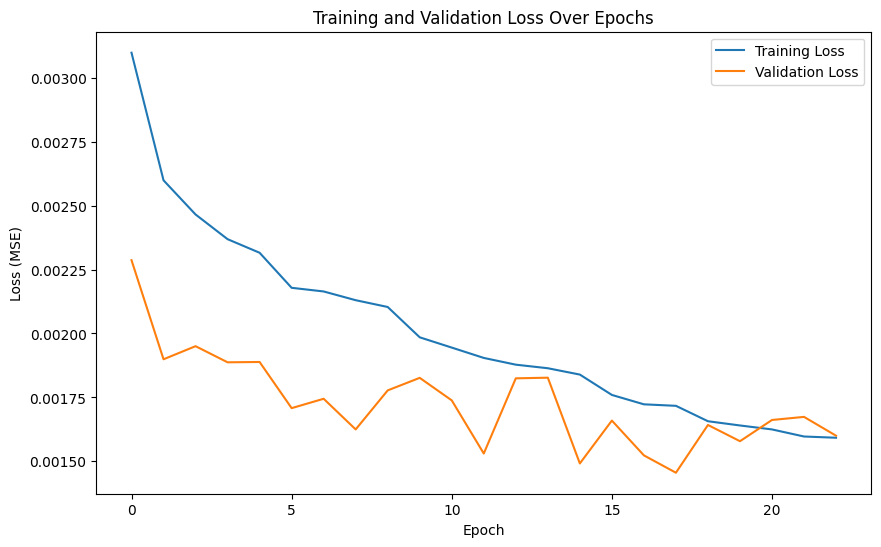

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

### Making predictions

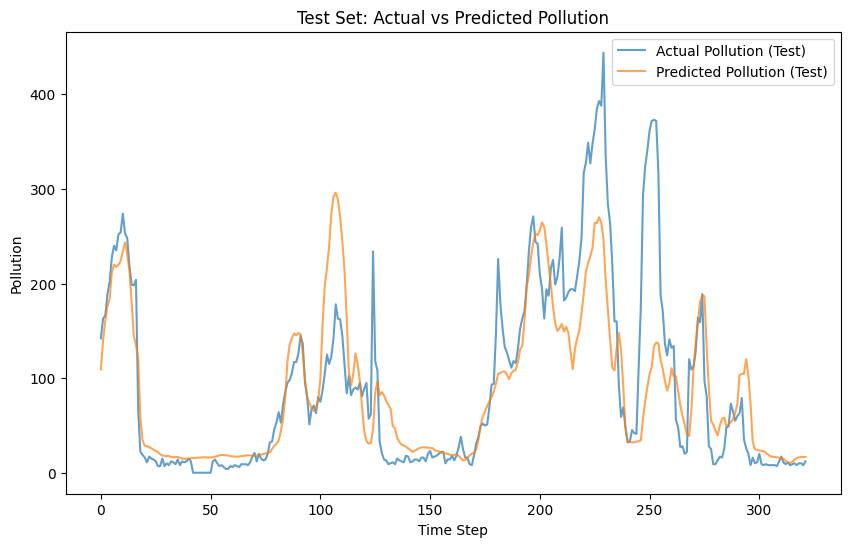

In [26]:
plt.figure(figsize=(10,6))
plt.plot(y_test_true,label='Actual Pollution (Test)',alpha=0.7)
plt.plot(y_test_pred,label='Predicted Pollution (Test)',alpha=0.7)
plt.title('Test Set: Actual vs Predicted Pollution')
plt.xlabel('Time Step')
plt.ylabel('Pollution')
plt.legend()
plt.show()

### Plotting the predictions

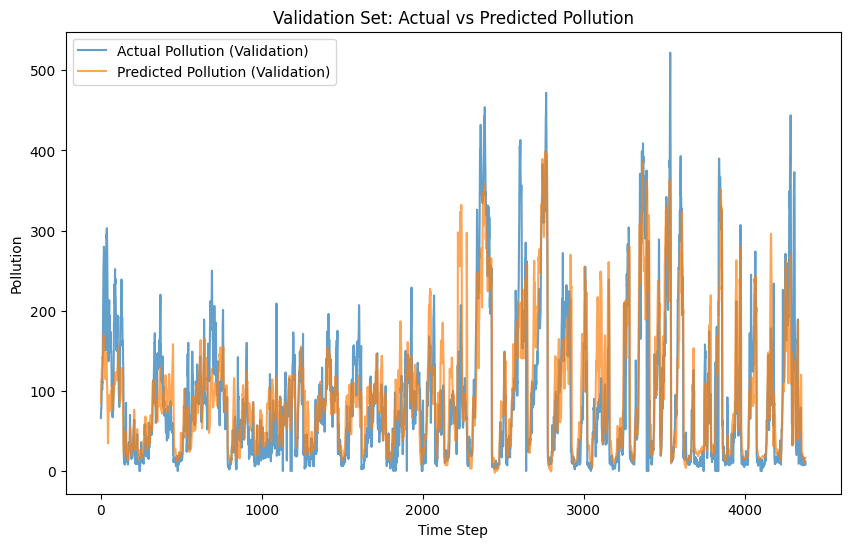

In [27]:
plt.figure(figsize=(10,6))
plt.plot(y_val_true,label='Actual Pollution (Validation)',alpha=0.7)
plt.plot(y_val_pred,label='Predicted Pollution (Validation)',alpha=0.7)
plt.title('Validation Set: Actual vs Predicted Pollution')
plt.xlabel('Time Step')
plt.ylabel('Pollution')
plt.legend()
plt.show()